***Importaré las librerías necesarias para llevar a cabo este proyecto***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import spacy
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout, BatchNormalization,GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Input
from gensim.models import KeyedVectors
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import joblib
!pip install xgboost



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#versiones
tensorflow_version = tf.__version__
keras_version = tf.keras.__version__

In [4]:
print(f"Versión de TensorFlow: {tensorflow_version}")
print(f"Versión de Keras: {keras_version}")

Versión de TensorFlow: 2.17.1
Versión de Keras: 3.5.0


***Conecto mi google drive con el cuaderno para acceder a los archivos que tenga como, por ejemplo, el csv con los sms***

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##**CARGA Y ANÁLISIS PREVIO DE LOS DATOS**

***Cargaré el dataset con los sms de spam y no spam sacados de la página web de kaggle***

In [ ]:
df_sms = pd.read_csv("/content/drive/My Drive/Proyecto_IA/spam.csv", encoding= 'latin-1')

In [ ]:
df_sms.head() #Echo un vistazo a los datos

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


***Cambiaré el nombre de las columnas para que sea más visual e intuitivo, además de eliminar esas columnas de Unnamed que no sirven. Solo necesito las etiquetas y los sms***

In [ ]:
df_sms = df_sms.iloc[:,:2]

In [ ]:
df_sms = df_sms.copy()

In [ ]:
df_sms.rename(columns = {'v1': 'etiqueta', 'v2': 'sms'}, inplace = True)

In [ ]:
df_sms.head() #comprobación

,etiqueta,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


***Como vistazo general de los datos veo que contamos con 5572 sms y ningún valor nulo. El número de registros no es muy alto, pero nos servirá para tener un acercamiento aproximado de la realidad a la hora de predecir y obtener un modelo decente que pueda predecir si el sms es spam o no spam***

In [ ]:
df_sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   etiqueta  5572 non-null   object
 1   sms       5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
list(df_sms[df_sms["etiqueta"]=="spam"]["sms"].iloc[501:601])

['Mila, age23, blonde, new in UK. I look sex with UK guys. if u like fun with me. Text MTALK to 69866.18 . 30pp/txt 1st 5free. å£1.50 increments. Help08718728876',
 'Claim a 200 shopping spree, just call 08717895698 now! Have you won! MobStoreQuiz10ppm',
 'Want to funk up ur fone with a weekly new tone reply TONES2U 2 this text. www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply',
 "Twinks, bears, scallies, skins and jocks are calling now. Don't miss the weekend's fun. Call 08712466669 at 10p/min. 2 stop texts call 08712460324(nat rate)",
 'We tried to contact you re your reply to our offer of a Video Handset? 750 anytime any networks mins? UNLIMITED TEXT? Camcorder? Reply or call 08000930705 NOW',
 'URGENT! We are trying to contact you. Last weekends draw shows that you have won a å£900 prize GUARANTEED. Call 09061701851. Claim code K61. Valid 12hours only',
 '74355 XMAS iscoming & ur awarded either å£500 CD gift vouchers & free entry 2 r å£100 weekly dr

***PORCENTAJE DE SPAM Y NO SPAM***

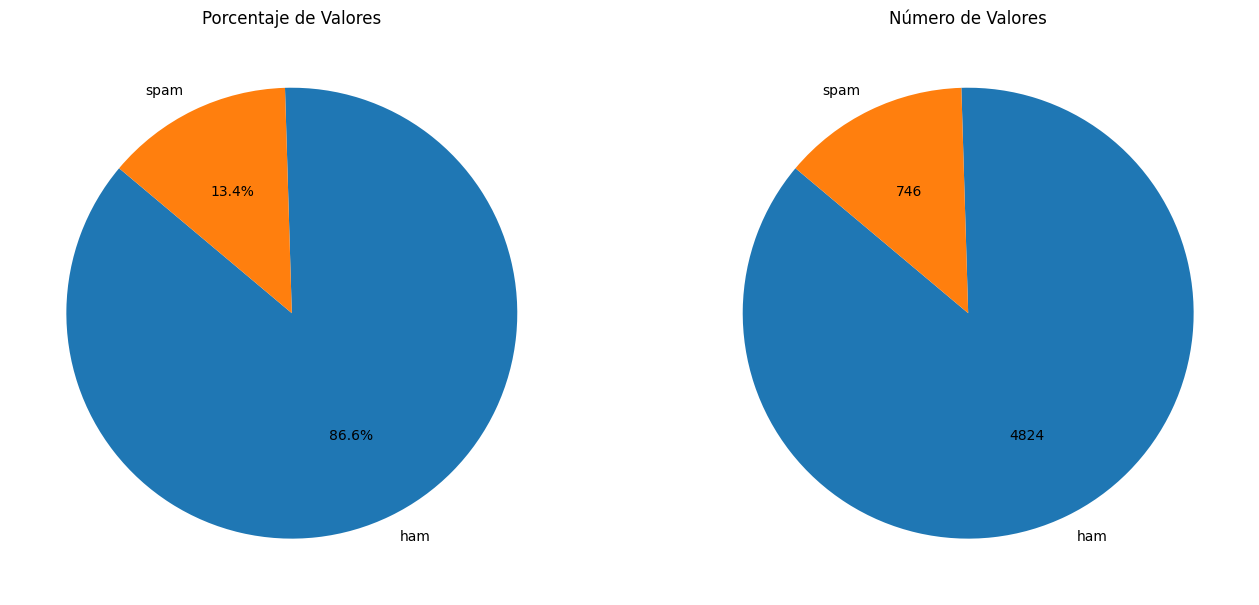

In [ ]:

etiqueta_counts = df_sms['etiqueta'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico circular con porcentajes
etiqueta_counts.plot.pie(autopct='%1.1f%%', startangle=140, ax=axs[0])
axs[0].set_title('Porcentaje de Valores')
axs[0].set_ylabel('')

# Gráfico circular con números
etiqueta_counts.plot.pie(autopct=lambda p: f'{int(p * etiqueta_counts.sum() / 100)}', startangle=140, ax=axs[1])
axs[1].set_title('Número de Valores')
axs[1].set_ylabel('')

plt.show()


***Como se puede apreciar hay un claro desbalanceo de los datos habiendo mucha más diferencia y mayor número de sms no spam que de spam. Esto será clave a la hora del entrenamiento del modelo que sabrá predecir mayoritariamente los casos de sms no spam, y por tanto, del sobreajuste y de datos sesgados, por lo que pasaremos a una estrategia crucial para resolver el problema. He probado buscar otros dataset, en este caso con correos de spam que quería añadir a este para equlibrar al mismo número de mensajes de no spam con el de spam, pero me resulto bastante complicado encontrar dataset buenos que no esten demasiado sucios o que tengan una estructura o estilo similar a los sms, asique decidí mediante data argumentacion generar mensajes ficticios.Implementaré un generador de mensajes de spam donde buscare aumentar la diversidad con un dataset de SMS ficticios. Al combinar múltiples frases de inicio, acciones y cierres, generaré mensajes únicos mediante un conjunto ampliado de vocabulario y valores numéricos variables. La estructura evitará duplicados al verificar la unicidad de cada mensaje.***

### **DATA ARGUMENTATION**


***Crearé un código que generara mensajes de spam ficticios basándome en ciertos requisitos y dando realismo y diversidad a cada uno de ellos. La idea es que se parezcan a los del dataset original.***

***Construiré una listas de frases: Crearé listas (entradas, temas_y_acciones, y cierres) con frases variadas, incluyendo sinónimos y diferentes estilos para mejorar la diversidad de los mensajes.***

 ***Haré generadores de URL y Teléfono para añadir realismo.
Aplicaré símbolos como $ y % y mayúsculas aleatorias, simulando patrones comunes en mensajes de spam.***

***Combinaré frases, URLs y números aleatorios con formato y símbolos para crear un mensaje único de spam.***

***Control de duplicados:  usaré un conjunto (set) para asegurar 4000 mensajes sin duplicados.***

In [ ]:
import random



# Listas ampliadas con frases de entrada, temas, acciones, y cierres
entradas = [
    "Urgent!", "Congratulations!", "Dear Customer,", "Important!", "Private Message:",
    "Exclusive offer:", "Win now!", "Act fast!", "Hurry up!",
    "Alert:", "Attention!", "Limited-time offer:", "Hello,", "Exciting news!",
    "Just for you:", "Immediate attention required", "Your reward awaits", "Special invitation:",
    "Great opportunity!", "Don't miss out!", "Flash sale:", "Final notice:", "VIP offer:",
    "Top priority:", "Your gift inside!", "Bonus reward:"
]

temas_y_acciones = [
    "You've been selected for a chance to win a £500 voucher!", "Win £1000 instantly by replying now!",
    "Your number won a prize in our weekly draw!", "Claim your entry for a chance to win a shopping spree!",
    "Exclusive deal: 50 percent off on your next purchase!", "Get a free subscription for the first month!",
    "Redeem your special prize today!", "Limited-time offer just for you!", "Special bonus for selected users!",
    "Unlock a 40 percent discount today!", "Claim your £200 reward instantly!", "You've been chosen for a special prize!",
    "You've qualified for a bonus reward!", "Your loyalty earned you a £150 discount!",
    "Exclusive invitation to our flash sale!", "You've unlocked a secret reward - claim now!",
    "Get £100 in shopping credits!", "Special prize draw: Win instantly!",
    "Earn cashback on your next purchase!", "Free gift with your next order!",
    "Congratulations! You've earned a free month of premium access!", "Limited time only: Join our exclusive prize draw!",
    "Just for you: Get an extra discount on your next order!", "Act now! Last chance to redeem your prize!",
    "Unlock your surprise reward today!", "You're invited to our VIP sale – shop now!",
    "Loan for any purpose up to £75,000. Call Free now!", "Claim your FREE mobile upgrade. Exclusive offer for loyal users!",
    "Congrats! You've won a Nokia 3650 phone. Call now to claim!", "URGENT: Your mobile has been awarded a £2000 bonus!",
    "Final chance to win a shopping spree worth £5000!", "UpgrdCentre: FREE Camera Phone upgrade for valued customers",
    "Special cinema pass for 2, valid for 1 year. Call now!", "Your mobile number has won a cash prize of £1000!",
    "Loan approved! Call now to finalize up to £50000.", "New video phone with 750 mins and 150 texts included. Act now!"
]

cierres = [
    "Offer valid for 24 hours only.", "Reply STOP to unsubscribe.", "Call now at 0871 555 9876.",
    "Limited to the first 100 responders.", "Act fast to avoid missing out.",
    "Valid until midnight.", "Send STOP to cancel.", "Don’t miss out!", "Claim before it expires!",
    "Save up to 50 percent now!", "T&Cs apply.", "First-time users only.", "Restrictions may apply.",
    "This offer won't last!", "Click here to redeem.", "Available for a limited time.",
    "Offer ends soon!", "Valid only for today.", "Conditions apply.",
    "First come, first served.", "One-time opportunity.", "Bonus expires shortly.",
    "Limited availability.", "Grab it while it lasts.", "Available exclusively for selected customers.",
    "Don’t let this opportunity slip away!", "Hurry, offer expires soon!", "Last chance to save!",
    "Act now before it's too late!", "Exclusive access for a limited time only.", "Your chance to win ends soon!"
]

# Funciones para generar URL, números telefónicos, y añadir variaciones de formato
def generar_url():
    dominios = ["freesample4u", "claimoffer4u", "rewardsnow", "exclusiveprizes", "winbig"]
    extensiones = [".com", ".net", ".org"]
    return f"www.{random.choice(dominios)}{random.choice(['', '-special', '2023'])}{random.choice(extensiones)}"

def generar_numero():
    prefijos = ["0871", "090", "0800", "+44 20", "+44 845"]
    return f"{random.choice(prefijos)} {random.randint(100, 999)} {random.randint(1000, 9999)}"

def aplicar_simbolos_y_formato(texto):
    # Añado variabilidad leve en el formato
    if random.random() < 0.3:
        texto = texto.replace("1000", "£1000").replace("500", "£500").replace("50%", "50 percent")
    if random.random() < 0.2:
        texto = texto.lower()
    if random.random() < 0.15:
        texto = texto.replace("!", ".")
    # Convierto palabras clave a mayúsculas en un 20% de los casos
    palabras_clave = ["win", "free","free!" "urgent","urgent!"
    ,"exclusive","exclusive!", "reward","reward!", "bonus", "offer","offer!","congratulations!"
    ,"congratulations","alert","alert!","credit","credit!","selected"
    ,"selected!","stop","stop!","now","now!","call","call!","mobile","mobile!"]
    if random.random() < 0.30:
        for palabra in palabras_clave:
            texto = texto.replace(palabra, palabra.upper())
    return texto

def generar_detalles_legales():
    detalles = [
        "T&Cs apply", "For users 18+", "Restrictions apply",
        "Offer subject to change", "First-time users only", "See site for details",
        "Not available in all areas", "One per user", "Limited availability applies"
    ]
    return random.choice(detalles)

# Generador de mensaje spam con mejoras en estilo y variación de formato
def generar_mensaje_spam():
    entrada = aplicar_simbolos_y_formato(random.choice(entradas))
    accion = aplicar_simbolos_y_formato(random.choice(temas_y_acciones))
    extra = random.choice([f"Visit {generar_url()}", f"Call {generar_numero()}", ""]) if random.random() < 0.25 else ""  # Limitamos URLs a 25%
    cierre = aplicar_simbolos_y_formato(random.choice(cierres))
    detalles_legales = f" ({generar_detalles_legales()})" if random.random() < 0.25 else ""

    # Variación en el orden de los elementos
    if random.random() < 0.2:
        return f"{accion} {entrada} {extra}. {cierre}{detalles_legales}"
    else:
        return f"{entrada} {accion} {extra}. {cierre}{detalles_legales}"

# Generador de mensajes únicos
def generar_mensajes_spam(n=4000):
    mensajes = set()
    while len(mensajes) < n:
        mensaje = generar_mensaje_spam()
        mensajes.add(mensaje)
    return list(mensajes)

# Genero 4000 mensajes de ejemplo
mensajes_generados = generar_mensajes_spam(4000)
for mensaje in mensajes_generados[:40]:  # Muestra los primeros 40 como ejemplo
    print(mensaje)


Your gift inside! Your loyalty earned you a £150 discount! . Restrictions may apply.
Your number won a prize in our weekly draw! Don't miss out! . First come, first served.
great opportunity! Loan approved! Call now to finalize up to £50000. . available for a limited time.
Win now! Your number won a prize in our weekly draw! . First come, first served.
Redeem your special prize today! Flash sale: Visit www.claimoffer4u-special.net. Offer valid for 24 hours only. (One per user)
Claim your FREE mobile upgrade. Exclusive offer for loyal users! attention! . Valid until midnight.
Unlock a 40 percent discount today. Top priority: . available for a limited time. (For users 18+)
Limited time only: Join our exclusive prize draw! Limited-time offer: Visit www.exclusiveprizes.com. exclusive access for a limited time only.
Top priority: UpgrdCentre: FREE Camera Phone upgrade for valued customers . Don’t miss out!
Exciting news. limited time only: join our exclusive prize draw! . Offer ends soon!
i

## **PREPROCESAMIENTO DE TEXTO**

***Hay que ser delicado con el preprocesamiento ya que no nos interesa nada eliminar elementos clave que puedan referirse a spam, como números, porcentajes, URls, o palabras como win, offer, free...***

***Agregaré esos 4000 mensajes de spam al data original etiquetados como spam***

In [ ]:
len(mensajes_generados)

4000

In [ ]:
# Creo la columna de marcador en los mensajes generados
spam_generados = pd.DataFrame({
    'sms': mensajes_generados,
    'etiqueta': 'spam',
    'origen': 'ficticio'  # Marco como mensajes ficticios
})

# Marco los mensajes originales
df_sms['origen'] = 'original'

# Combino ambos conjuntos de datos
sms_equilibrado = pd.concat([df_sms, spam_generados], ignore_index=True)


In [ ]:
sms_equilibrado

,etiqueta,sms,origen
0,ham,"Go until jurong point, crazy.. Available only ...",original
1,ham,Ok lar... Joking wif u oni...,original
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,original
3,ham,U dun say so early hor... U c already then say...,original
4,ham,"Nah I don't think he goes to usf, he lives aro...",original
...,...,...,...
9567,spam,Free gift with your next order. Immediate atte...,ficticio
9568,spam,Alert: Special prize draw: Win instantly. . Av...,ficticio
9569,spam,Limited-time offer: Exclusive deal: 50 percent...,ficticio
9570,spam,"Dear Customer, earn cashback on your next purc...",ficticio


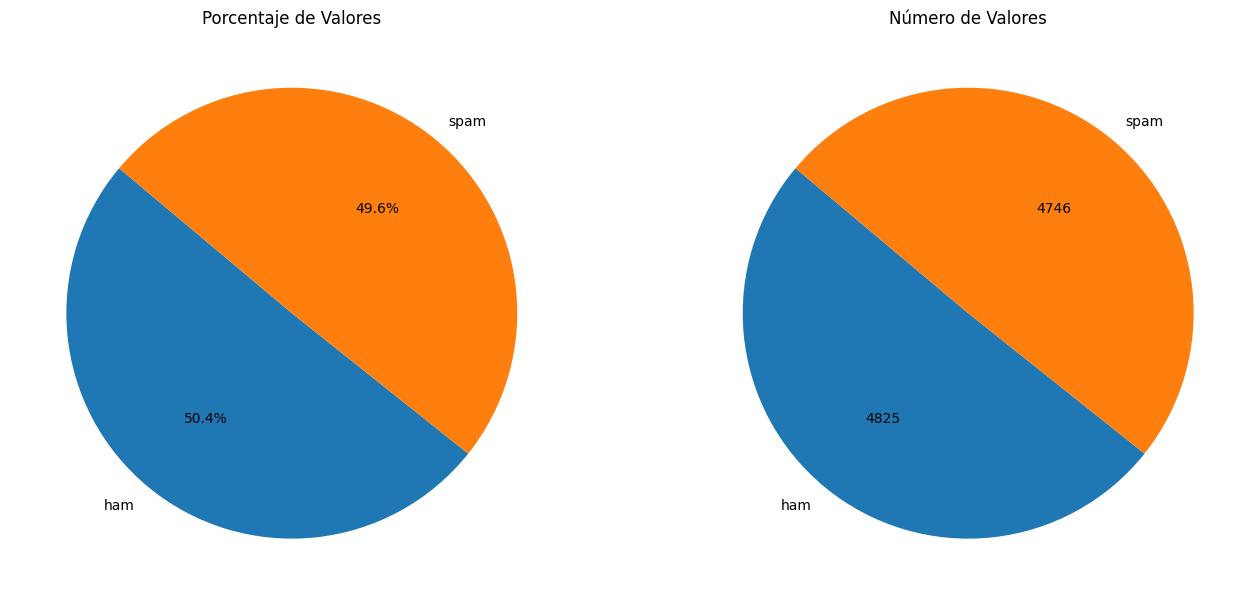

In [ ]:

etiqueta_counts = sms_equilibrado['etiqueta'].value_counts()

# Creo dos gráficos circulares
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico circular con porcentajes
etiqueta_counts.plot.pie(autopct='%1.1f%%', startangle=140, ax=axs[0])
axs[0].set_title('Porcentaje de Valores')
axs[0].set_ylabel('')

# Gráfico circular con números
etiqueta_counts.plot.pie(autopct=lambda p: f'{int(p * etiqueta_counts.sum() / 100)}', startangle=140, ax=axs[1])
axs[1].set_title('Número de Valores')
axs[1].set_ylabel('')

plt.show()


***AHORA SI TENEMOS UN DATASET EQUILIBRADO***

In [ ]:
sms_equilibrado.to_csv( '/content/drive/My Drive/Proyecto_IA/sms_equilibrado.csv', index=False) #exportare el dataframe para posibles usos

In [ ]:
sms_equilibrado = pd.read_csv('/content/drive/My Drive/Proyecto_IA/sms_equilibrado.csv')

**INGENIERIA DE CARACTERÍSTICAS**

***Agregaré nuevas características para enriquecer mis datos y a su vez el modelo.
¿Cuáles?***



**_special_char_count:_** Número de caracteres especiales en el mensaje, como @, $, % o &, que son comunes en mensajes de spam.

**_exclamation_count:_** Cantidad de signos de exclamación, ya que los mensajes de spam a menudo usan exclamaciones para enfatizar ofertas o urgencia.

**_number_count:_** Número de dígitos presentes en el mensaje. Los mensajes de spam suelen incluir números para montos de dinero, códigos o números de contacto.

**_emoticon_count:_** Cantidad de emoticonos en el mensaje, que son más comunes en mensajes no spam o personales.

**_message_length:_** Longitud total del mensaje en caracteres. Los mensajes de spam tienden a ser breves y directos, mientras que los mensajes no spam pueden variar en longitud.

**_spam_word_count:_** Cantidad de palabras comunes en spam, como "win", "free", "offer", etc. Ayuda a identificar palabras que se suelen usar en mensajes de spam.

**_stop_word_ratio:_** Proporción de palabras vacías (stop words) sobre el total de palabras. Los mensajes no spam suelen contener más palabras vacías.

**_uppercase_word_count:_** Número de palabras completamente en mayúsculas, como "WIN" o "OFFER". Estas palabras suelen aparecer en mensajes de spam.

**_url_count:_** Cantidad de URLs en el mensaje. Los mensajes de spam suelen incluir enlaces para redirigir a sitios externos.




In [ ]:
from nltk.corpus import stopwords

# Defino los nombres de las columnas de características
feature_columns = [
    'special_char_count',
    'exclamation_count',
    'number_count',
    'emoticon_count',
    'message_length',
    'spam_word_count',
    'stop_word_ratio',
    'uppercase_word_count',
    'url_count'
]

# Lista de palabras comunes en mensajes de spam
spam_words = ["win", "free","free!" "urgent","urgent!","urgent.","attention","attention!","oportunity!","oportunity.","oportunity",
              "exclusive","exclusive!", "reward","reward!", "bonus","bonus." "offer","offer!","congratulations!"
    ,"congratulations","alert","alert!","credit","credit!","selected","private!","clik!","clik","click here","click now","click now!","click on","click on!","click here!","click in",
    "selected!","stop","stop!","now","now!","call now","call now!","mobile","mobile!","vip","vip!","vip.","importan","important.","important!"]

# Función para calcular características
def calculate_features(text):
    # Longitud total del texto
    total_chars = len(text)
    if total_chars == 0:
        return [0] * len(feature_columns)  # Si el texto está vacío, retorna ceros para cada característica

    # Conteo de caracteres especiales
    special_characters_pattern = r'[!?.@$%&*()\-+/#:;<>]'  # Caracteres especiales relevantes
    special_char_count = len(re.findall(special_characters_pattern, text))

    # Conteo de exclamaciones
    exclamation_count = text.count('!')

    #Conteo de números
    number_count = len(re.findall(r'\d+', text))

    #conteo emoticono

    emoticon_pattern = r'(?<!\+)(?<!\w)([:;=xX][\-~]?[)DdpP(]|<3|[)D]|[:(][\-~]?[)D]|[oO0][\.]?|[>])(?<!\w)'
    emoticon_count = len(re.findall(emoticon_pattern, text))


    # Longitud total del mensaje en caracteres
    message_length = total_chars

    # Conteo de palabras de spam comunes
    spam_word_count = sum(1 for word in text.lower().split() if word in spam_words)

    # Conteo y proporción de stop words
    stop_words = set(stopwords.words('english'))
    stop_word_count = sum(1 for word in text.lower().split() if word in stop_words)
    word_count = len(text.split())
    stop_word_ratio = stop_word_count / word_count if word_count > 0 else 0

    # Conteo de palabras en mayúsculas
    uppercase_word_count = sum(1 for word in text.split() if word.isupper())
    uppercase_word_freq = uppercase_word_count / word_count if word_count > 0 else 0  # Frecuencia de palabras en mayúsculas


    # Conteo de URLs en el mensaje
    # Expresión regular  para URLs típicas y dominios comunes
    url_regex = r"(http[s]?://\S+|www\.\S+|\S+\.(com|org|net|co\.uk|gov|edu|biz|info|in))"
    # Expresión regular para frases relacionadas con URLs indirectas comunes en spam
    keywords = r"(click here|visit|offer|more info|details|exclusive|redeem|promotion)"

    url_regex = r"(http[s]?://\S+|www\.\S+|\S+\.(com|org|net|co\.uk|gov|edu|biz|info|in))"
    # Expresión regular para frases relacionadas con URLs indirectas
    keywords = r"(click here|visit|offer|more info|details|exclusive|redeem|promotion)"

    # Buscar coincidencias de URLs explícitas
    url_matches = re.findall(url_regex, text, re.IGNORECASE)

    # Solo registro palabras clave si no hay URLs explícitas
    if url_matches:
        url_count = len(url_matches)
    else:
        url_count = 0

    return [
        special_char_count,
        exclamation_count,
        number_count,
        emoticon_count,
        message_length,
        spam_word_count,
        stop_word_ratio,
        uppercase_word_count,
        url_count
    ]


sms_equilibrado[feature_columns] = sms_equilibrado['sms'].apply(calculate_features).apply(pd.Series)


In [ ]:
sms_equilibrado.to_csv('/content/drive/My Drive/Proyecto_IA/new_features_sms.csv', index=False) #guardo porque fue un proceso costoso

In [ ]:
df_sms_features = pd.read_csv('/content/drive/My Drive/Proyecto_IA/new_features_sms.csv')

In [ ]:
df_sms_features.head()

,etiqueta,sms,origen,special_char_count,exclamation_count,number_count,emoticon_count,message_length,spam_word_count,stop_word_ratio,uppercase_word_count,url_count
0,ham,"Go until jurong point, crazy.. Available only ...",original,8.0,0.0,0.0,0.0,111.0,0.0,0.200000,0.0,0.0
1,ham,Ok lar... Joking wif u oni...,original,6.0,0.0,0.0,0.0,29.0,0.0,0.000000,0.0,0.0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,original,4.0,0.0,6.0,0.0,155.0,2.0,0.178571,2.0,0.0
3,ham,U dun say so early hor... U c already then say...,original,6.0,0.0,0.0,0.0,49.0,0.0,0.181818,2.0,0.0
4,ham,"Nah I don't think he goes to usf, he lives aro...",original,0.0,0.0,0.0,0.0,61.0,0.0,0.461538,1.0,0.0


In [ ]:

total_stats = df_sms_features.describe()


spam_stats = df_sms_features[df_sms_features['etiqueta'] == 'spam'].describe()
ham_stats = df_sms_features[df_sms_features['etiqueta'] == 'ham'].describe()


print("Estadísticas generales:")
total_stats



Estadísticas generales:


,special_char_count,exclamation_count,number_count,emoticon_count,message_length,spam_word_count,stop_word_ratio,uppercase_word_count,url_count
count,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000
mean,4.155871,0.781655,0.921020,0.044714,87.116799,0.817802,0.304449,0.877873,0.054116
std,3.349484,0.968831,1.684816,0.254284,47.932219,1.094063,0.151797,2.149132,0.232184
min,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,51.000000,0.000000,0.200000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000,86.000000,0.000000,0.296296,0.000000,0.000000
75%,6.000000,1.000000,1.000000,0.000000,112.000000,1.000000,0.400000,1.000000,0.000000
max,132.000000,11.000000,14.000000,7.000000,910.000000,6.000000,0.875000,37.000000,2.000000


In [ ]:
print("\nEstadísticas para mensajes de spam:")
spam_stats



Estadísticas para mensajes de spam:


,special_char_count,exclamation_count,number_count,emoticon_count,message_length,spam_word_count,stop_word_ratio,uppercase_word_count,url_count
count,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000
mean,5.183906,1.399410,1.598062,0.002949,103.474405,1.591742,0.246403,0.930904,0.102380
std,1.814074,0.878252,2.018827,0.108585,26.098527,1.078737,0.101219,1.523612,0.310731
min,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,0.000000,0.000000,84.000000,1.000000,0.166667,0.000000,0.000000
50%,5.000000,1.000000,1.000000,0.000000,99.000000,1.000000,0.250000,0.000000,0.000000
75%,6.000000,2.000000,2.000000,0.000000,118.000000,2.000000,0.315789,1.000000,0.000000
max,26.000000,5.000000,12.000000,7.000000,224.000000,6.000000,0.666667,27.000000,2.000000


In [ ]:

print("\nEstadísticas para mensajes de ham:")
ham_stats


Estadísticas para mensajes de ham:


,special_char_count,exclamation_count,number_count,emoticon_count,message_length,spam_word_count,stop_word_ratio,uppercase_word_count,url_count
count,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000
mean,3.144456,0.173886,0.254922,0.085803,71.023627,0.056373,0.361557,0.825699,0.006632
std,4.118032,0.598698,0.852813,0.336575,58.016023,0.246310,0.170469,2.621920,0.086132
min,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,33.000000,0.000000,0.250000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,52.000000,0.000000,0.375000,0.000000,0.000000
75%,4.000000,0.000000,0.000000,0.000000,92.000000,0.000000,0.500000,1.000000,0.000000
max,132.000000,11.000000,14.000000,5.000000,910.000000,3.000000,0.875000,37.000000,2.000000


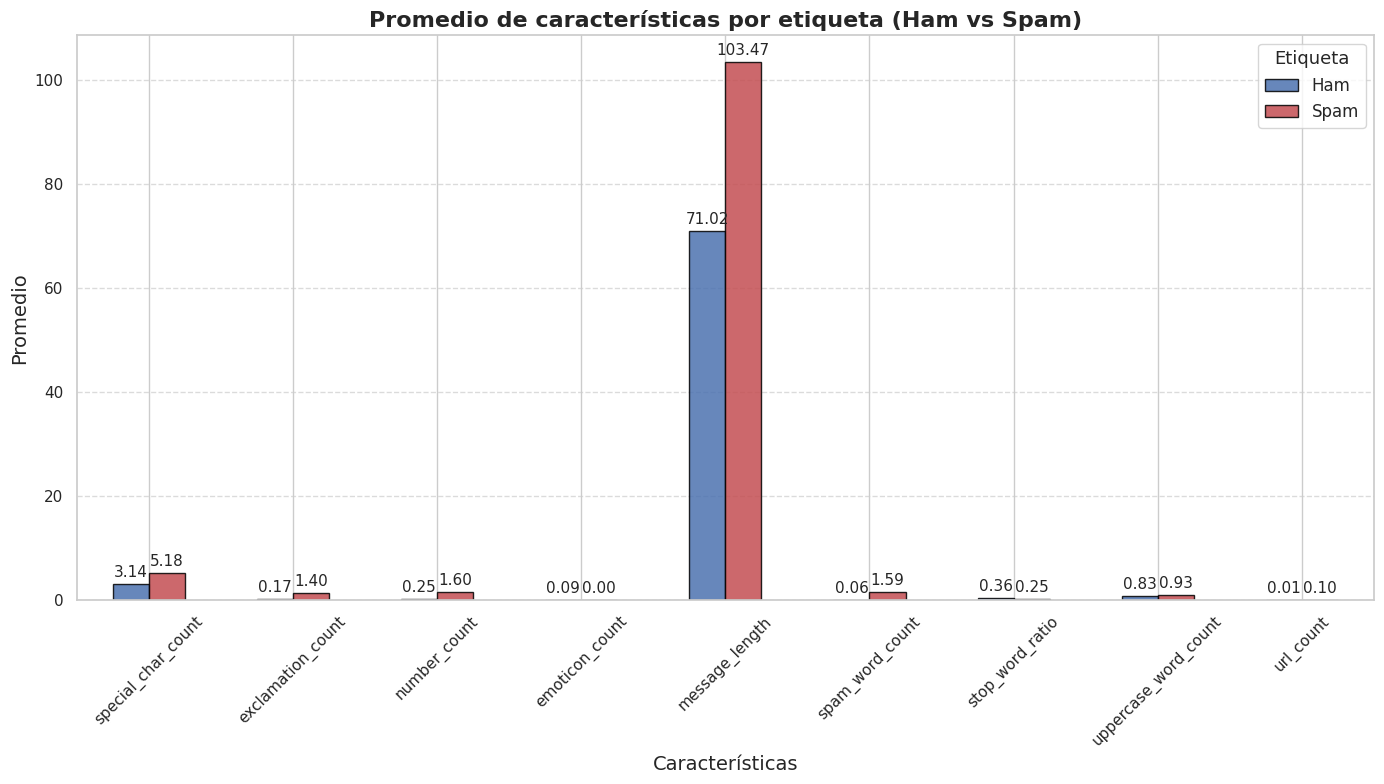

In [ ]:

feature_columns = df_sms_features.drop(['sms','etiqueta','origen'], axis=1).columns.tolist()


feature_means = df_sms_features.groupby("etiqueta")[feature_columns].mean()


sns.set(style="whitegrid")


fig, ax = plt.subplots(figsize=(14, 8))
feature_means.T.plot(kind="bar", ax=ax, color=["#4c72b0", "#c44e52"], alpha=0.85, edgecolor='black')


ax.set_title("Promedio de características por etiqueta (Ham vs Spam)", fontsize=16, fontweight='bold')
ax.set_xlabel("Características", fontsize=14)
ax.set_ylabel("Promedio", fontsize=14)
ax.legend(title="Etiqueta", labels=["Ham", "Spam"], fontsize=12, title_fontsize='13')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)


for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=11, padding=3)

plt.tight_layout()
plt.show()

***Resumen de estadísticas de spam vs ham:***

***Caracteres especiales: Los mensajes de spam tienen en promedio más caracteres especiales (5.19) que los mensajes normales (ham) (3.14), que parece puede ser normal ya que en mensajes spam hay más simbolos de porcentaje, de dinero, Urls..***

***Signos de exclamación: Es común que los mensajes de spam tengan más exclamaciones (media de 1.4) frente a ham (0.17).***

***Conteo de números: Spam incluye más números (1.60 en promedio) que ham (0.25), qu epuede ser por números telefónicos, números de precio...***

***Longitud del mensaje: Los mensajes de spam suelen ser más largos (media de 103 caracteres) que los de ham (71 caracteres).***

***Palabras clave de spam: Aparecen más frecuentemente en spam (1.59) que en ham (0.06) como era de esperar ya que me asegur4é de incluir bastantes palabras claves que tienen siempre los spam.***

***Proporción de palabras comunes: Más baja en spam (0.25) que en ham (0.36), indicando menor naturalidad en el lenguaje de spam.***

***Palabras en mayúsculas: Spam presenta más palabras en mayúsculas (0.93 en promedio) frente a ham (0.83), y esto es debido a enfatizar algunas palabras en mayúscula debido a ofertas o promociones comerciales por ejempolo.***

***URLs: Aunque es raro en ambos, el spam muestra más URLs (0.10) comparado con ham (0.01). Es lógico pensar que los spam incluyen más URLS, que los de no spam***

In [ ]:
df_sms_features.head()

,etiqueta,sms,origen,special_char_count,exclamation_count,number_count,emoticon_count,message_length,spam_word_count,stop_word_ratio,uppercase_word_count,url_count
0,ham,"Go until jurong point, crazy.. Available only ...",original,8.0,0.0,0.0,0.0,111.0,0.0,0.200000,0.0,0.0
1,ham,Ok lar... Joking wif u oni...,original,6.0,0.0,0.0,0.0,29.0,0.0,0.000000,0.0,0.0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,original,4.0,0.0,6.0,0.0,155.0,2.0,0.178571,2.0,0.0
3,ham,U dun say so early hor... U c already then say...,original,6.0,0.0,0.0,0.0,49.0,0.0,0.181818,2.0,0.0
4,ham,"Nah I don't think he goes to usf, he lives aro...",original,0.0,0.0,0.0,0.0,61.0,0.0,0.461538,1.0,0.0


###**PREPROCESAMIENTO DE TEXTO**

***Haré una función que limpie los sms***

In [ ]:

import spacy

# Cargo modelo spacy en ingles
nlp = spacy.load('en_core_web_sm')

def limpiar_texto_spacy(texto):
    # Normalizo a minúsculas
    texto = texto.lower()

    # Etiqueto URLs como <url>
    texto = re.sub(r'http\S+|www\.\S+', 'url', texto)

    # Etiqueto números como <numero>
    texto = re.sub(r'\b\d+\b', 'number', texto)

    # Elimino cualquier carácter especial restante
    texto = re.sub(r'[^a-zA-Z0-9\s<>\s]', '', texto)

    # Proceso el texto con spaCy
    doc = nlp(texto)

    # Filtro stopwords, puntuación y lematizo
    texto_limpio = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

    return texto_limpio


df_sms_features['mensaje_limpio'] = df_sms_features['sms'].apply(limpiar_texto_spacy)


print(df_sms_features[['sms', 'mensaje_limpio']].head())


                                                 sms  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                      mensaje_limpio  
0  jurong point crazy available bugis n great wor...  
1                              ok lar joke wif u oni  
2  free entry number wkly comp win fa cup final t...  
3                                u dun early hor u c  
4                          nah not think go usf live  


In [ ]:


sms_ejemplos = df_sms_features[df_sms_features["url_count"] == 1][["sms", "mensaje_limpio"]].head(50)


lista_sms_ejemplos = [list(fila) for fila in sms_ejemplos.itertuples(index=False)]

# Imprimo cada SMS original junto a su versión limpia
for i, (sms, sms_limpio) in enumerate(lista_sms_ejemplos):
    print(f"\nSMS {i + 1} Original: {sms}")
    print(f"SMS {i + 1} Limpio: {sms_limpio}")



SMS 1 Original: URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
SMS 1 Limpio: urgent win number week free membership numbernumber prize jackpot txt word claim number tc url lccltd pobox 4403ldnw1a7rw18

SMS 2 Original: I only haf msn. It's yijue@hotmail.com
SMS 2 Limpio: haf msn yijuehotmailcom

SMS 3 Original: -PLS STOP bootydelious (32/F) is inviting you to be her friend. Reply YES-434 or NO-434 See her: www.SMS.ac/u/bootydelious STOP? Send STOP FRND to 62468
SMS 3 Limpio: pls stop bootydelious numberf invite friend reply yesnumber nonumber url stop send stop frnd number

SMS 4 Original: Are you unique enough? Find out from 30th August. www.areyouunique.co.uk
SMS 4 Limpio: unique find 30th august url

SMS 5 Original: 500 New Mobiles from 2004, MUST GO! Txt: NOKIA to No: 89545 & collect yours today!From ONLY å£1 www.4-tc.biz 2optout 087187262701.50gbp/mtmsg18
SMS 5 Limpio: num

***Manejo de palabras raras o erróneas***

***Voy a contemplar las palabras más comunes y menos comunes de los textos haber si me cuadra y sino modificar ciertos detalles***

In [ ]:
from collections import Counter


todos_los_textos = " ".join(df_sms_features['mensaje_limpio'])


palabras = re.findall(r'\b\w+\b', todos_los_textos)

# Cuento las palabras mas frecuentes
frecuencia_palabras = Counter(palabras)

# Muestro palabras más comunes
print(frecuencia_palabras.most_common(50))

#palabras menos comunes
print([palabra for palabra, freq in frecuencia_palabras.items() if freq <= 5])


[('number', 6541), ('offer', 1367), ('not', 1286), ('win', 1283), ('u', 1119), ('free', 973), ('prize', 900), ('reward', 799), ('claim', 793), ('apply', 780), ('ve', 779), ('special', 776), ('exclusive', 720), ('chance', 709), ('user', 698), ('bonus', 663), ('act', 638), ('today', 632), ('time', 614), ('limited', 578), ('miss', 534), ('valid', 533), ('mobile', 500), ('m', 493), ('phone', 492), ('customer', 465), ('come', 456), ('soon', 451), ('url', 441), ('stop', 426), ('reply', 417), ('expire', 411), ('draw', 405), ('available', 404), ('send', 398), ('select', 390), ('ur', 384), ('opportunity', 370), ('redeem', 352), ('visit', 351), ('discount', 350), ('sale', 350), ('percent', 348), ('text', 347), ('instantly', 345), ('urgent', 338), ('go', 329), ('s', 323), ('earn', 321), ('unlock', 320)]
['jurong', 'buffet', 'amore', 'oni', 'fa', 'tkts', '21st', 'questionstd', 'ratetcs', '08452810075over18s', 'hor', 'darle', 'tb', 'chgs', 'rcv', 'aids', 'patent', 'oru', 'minnaminunginte', 'nurungu

***Es innegable que muchas palabras no tienen ningún tipo de sentido, habiendo palabras que siendo las más comunes no tienen significado como 'u' o 'm' por lo que sería bueno eliminar palabras de menos de dos caracteres. Es cierto que hay mucho ruido en el texto y que sería mucho trabajo tratar de limpiar esas palabras erroneas o sin sentido ya que por experiencia, acabaría con sms vacios o con una errónea detección de esas palabras equivocadas pudiendo eliminar palabras que realmente tienen significado. Además, algunos modelos se pueden aprovechar de estas palabras extrañas y detectarlas perfectamente sacándoles cierto partido como glove, embeddings o transformers que pueden captar el contexto semántico de esas palabras, asique tampoco es algo que me preocupe. Asique dejaré así el texto y unicamente eliminare palabras de menos de dos caracteres***

***Eliminar tokens de menos de dos caracteres***

In [ ]:


# Función para eliminar palabras con menos de 2 caracteres
def remove_short_words(text):
    # Dividiendo el texto en palabras, filtrar y unirlas de nuevo
    return " ".join([word for word in text.split() if len(word) > 1])

# Aplico la función a la columna 'mensaje_limpio'
df_sms_features['mensaje_limpio'] = df_sms_features['mensaje_limpio'].apply(remove_short_words)


# Combinando todos los mensajes en un solo string
todos_los_textos = " ".join(df_sms_features['mensaje_limpio'])


palabras = re.findall(r'\b\w+\b', todos_los_textos)

# Conteo frecuencia de cada palabra
frecuencia_palabras = Counter(palabras)

#palabras más comunes
print(frecuencia_palabras.most_common(50))

#palabras menos comunes
print([palabra for palabra, freq in frecuencia_palabras.items() if freq <= 5])



[('number', 6541), ('offer', 1367), ('not', 1286), ('win', 1283), ('free', 973), ('prize', 900), ('reward', 799), ('claim', 793), ('apply', 780), ('ve', 779), ('special', 776), ('exclusive', 720), ('chance', 709), ('user', 698), ('bonus', 663), ('act', 638), ('today', 632), ('time', 614), ('limited', 578), ('miss', 534), ('valid', 533), ('mobile', 500), ('phone', 492), ('customer', 465), ('come', 456), ('soon', 451), ('url', 441), ('stop', 426), ('reply', 417), ('expire', 411), ('draw', 405), ('available', 404), ('send', 398), ('select', 390), ('ur', 384), ('opportunity', 370), ('redeem', 352), ('visit', 351), ('discount', 350), ('sale', 350), ('percent', 348), ('text', 347), ('instantly', 345), ('urgent', 338), ('go', 329), ('earn', 321), ('unlock', 320), ('end', 318), ('get', 310), ('attention', 308)]
['jurong', 'buffet', 'amore', 'oni', 'fa', 'tkts', '21st', 'questionstd', 'ratetcs', '08452810075over18s', 'hor', 'darle', 'tb', 'chgs', 'rcv', 'aids', 'patent', 'oru', 'minnaminunginte

***Sigue habiendo palabras que no tienen significado pero como he dicho antes, conservaremos el ruido de los mensajes que luego corregirán los diferentes modelos que usaremos***

In [ ]:
df_sms_features.to_csv('/content/drive/My Drive/Proyecto_IA/sms_procesado.csv', index=False) #guardo el data con los textos limpios para seguir avanzando

In [6]:
df_sms_limpio = pd.read_csv("/content/drive/My Drive/Proyecto_IA/sms_procesado.csv", encoding= 'latin-1')

###**DIVISION DE ENTRENAMIENTO Y PRUEBA**

 ***División de no spam:***

***Dividiré el conjunto not_spam en un 70% para entrenamiento y un 30% para prueba.***

***División de spam original:***

***De los spam_original, tomaré el 50% para entrenamiento (junto con una pequeña fracción de los no spam originales) y el 50% para la prueba.***

***Entrenamiento:***

***El conjunto de entrenamiento se compone de todo el spam ficticio, el 70% de los no spam originales y el 10-20% de los mensajes spam originales (para equilibrar un poco).***

***Prueba:***

***El conjunto de prueba se compone de los spam originales y no spam originales, sin incluir los ficticios.***


***Entrenamiento (train_set): Contiene los mensajes ficticios, que son útiles para enseñar al modelo cómo clasificar mensajes spam, además de una fracción de los spam originales para asegurar que el modelo también vea ejemplos de spam reales durante el entrenamiento.***

***Prueba (test_set): Se evalúa el rendimiento final en un conjunto que refleja más fielmente una situación real, donde solo hay spam original y no spam original.***


***En resumen, el conjunto de prueba (test_set) ya no tiene mensajes ficticios, por lo que el rendimiento reflejará mejor cómo el modelo puede generalizar a nuevos datos que no haya visto antes (es decir, no se "sobreajusta" a los mensajes ficticios).***


In [7]:


spam_original = df_sms_limpio[(df_sms_limpio['etiqueta'] == 'spam') & (df_sms_limpio['origen'] == 'original')]
spam_ficticio = df_sms_limpio[(df_sms_limpio['etiqueta'] == 'spam') & (df_sms_limpio['origen'] == 'ficticio')]
not_spam = df_sms_limpio[df_sms_limpio['etiqueta'] == 'ham']


# Divido no spam original en entrenamiento y prueba
not_spam_train, not_spam_test = train_test_split(not_spam, test_size=0.30, random_state=42)

# Divido spam original entre validación y prueba (aunque solo usaré prueba para no incluir ficticios)
spam_original_train, spam_original_test = train_test_split(spam_original, test_size=0.50, random_state=42)

# Creo conjunto de entrenamiento con spam ficticio y una fracción de los no spam originales (70%)
train_set = pd.concat([spam_ficticio, not_spam_train, spam_original_train.sample(frac=0.10, random_state=42)])

# Creo conjunto de prueba con spam originales y no spam originales (solo originales)
test_set = pd.concat([spam_original_test, not_spam_test])

# Muestro tamaños finales de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {train_set.shape}")
print(f"Tamaño del conjunto de prueba: {test_set.shape}")


Tamaño del conjunto de entrenamiento: (7414, 13)
Tamaño del conjunto de prueba: (1822, 13)


### **PREPARAR LOS DATOS PARA EL MODELO**

***Necesario convertir en números las etiquetas de ham y spam en 0 y 1para que las entienda el modelo.***

In [8]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_set['etiqueta_num'] = le.fit_transform(train_set['etiqueta'])
test_set['etiqueta_num'] = le.transform(test_set['etiqueta'])


In [9]:
train_set["etiqueta_num"].value_counts()



,count
etiqueta_num,
1,4037
0,3377


***Eliminar columnas que ya no necesito como etiqueta, sms que es el texto en crudo y el origen***

In [10]:
columnas_importantes = [
    'special_char_count', 'exclamation_count', 'number_count', 'emoticon_count',
    'message_length', 'spam_word_count', 'stop_word_ratio',
    'uppercase_word_count', 'url_count', 'mensaje_limpio', 'etiqueta_num'
]

train_set = train_set[columnas_importantes]
test_set = test_set[columnas_importantes]


***Valores nulos***

***Se han quedado algunos mensajes vacíos seguramente por el preprocesamiento asique como no queremos eliminar esas filas porque perderíamos información de las otras características y son pocos, podemos sustituirlos por "mensaje_vacio"***

In [11]:

train_set.info()
test_set.info()



<class 'pandas.core.frame.DataFrame'>
Index: 7414 entries, 5572 to 5102
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   special_char_count    7414 non-null   float64
 1   exclamation_count     7414 non-null   float64
 2   number_count          7414 non-null   float64
 3   emoticon_count        7414 non-null   float64
 4   message_length        7414 non-null   float64
 5   spam_word_count       7414 non-null   float64
 6   stop_word_ratio       7414 non-null   float64
 7   uppercase_word_count  7414 non-null   float64
 8   url_count             7414 non-null   float64
 9   mensaje_limpio        7403 non-null   object 
 10  etiqueta_num          7414 non-null   int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 695.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1822 entries, 1455 to 2622
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------ 

In [12]:
# Relleno los valores nulos en 'mensaje_limpio' con "mensaje_vacio" en los dos conjuntos
train_set['mensaje_limpio'] = train_set['mensaje_limpio'].fillna("mensaje_vacio")
test_set['mensaje_limpio'] = test_set['mensaje_limpio'].fillna("mensaje_vacio")

# Verifico que no hay nulos en ninguno de los conjuntos
print(train_set['mensaje_limpio'].isna().sum())
print(test_set['mensaje_limpio'].isna().sum())


0
0


***Normalizar valores numéricos***

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Selecciono
numeric_columns = ['special_char_count', 'exclamation_count', 'number_count',
                   'emoticon_count', 'message_length', 'spam_word_count',
                   'stop_word_ratio', 'uppercase_word_count', 'url_count']

# Inicio scalador
scaler = MinMaxScaler()

# Ajusto y transformo los datos en los conjuntos de entrenamiento y test ajustando solo a los datos de entrenamiento
train_set[numeric_columns] = scaler.fit_transform(train_set[numeric_columns])
test_set[numeric_columns] = scaler.transform(test_set[numeric_columns])


In [14]:
train_set.head()

,special_char_count,exclamation_count,number_count,emoticon_count,message_length,spam_word_count,stop_word_ratio,uppercase_word_count,url_count,mensaje_limpio,etiqueta_num
5572,0.030303,0.181818,0.071429,0.0,0.090308,0.000000,0.326531,0.0,0.0,gift inside loyalty earn number discount restr...,1
5573,0.030303,0.181818,0.000000,0.0,0.093612,0.000000,0.403361,0.0,0.0,number win prize weekly draw not miss come serve,1
5574,0.037879,0.181818,0.071429,0.0,0.107930,0.166667,0.403361,0.0,0.0,great opportunity loan approve finalize number...,1
5575,0.030303,0.181818,0.000000,0.0,0.085903,0.333333,0.357143,0.0,0.0,win number win prize weekly draw come serve,1
5576,0.068182,0.090909,0.142857,0.0,0.136564,0.000000,0.126984,0.0,0.5,redeem special prize today flash sale visit ur...,1


***Separar en X e Y***

In [15]:

# Division del conjunto de datos en entrenamiento y test
X_train = train_set.drop('etiqueta_num', axis=1)
y_train = train_set['etiqueta_num']
X_test = test_set.drop('etiqueta_num', axis=1)
y_test = test_set['etiqueta_num']


***Estrategias para la columna de los mensajes***

### ***TFIDF***

***Probando modelos sin columnas nuevas que añadí***

In [ ]:
#preprocesador que solo use TF-IDF para el texto
preprocessor_sin_columnas = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(stop_words='english'), 'mensaje_limpio')
    ],
    remainder='drop'
)

# Lista de clasificadores a probar
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}


for clf_name, clf in classifiers.items():
    print(f"\nEvaluando {clf_name}...")

    # Creo el pipeline con el clasificador
    pipeline = Pipeline([
        ('preprocessor', preprocessor_sin_columnas),
        (clf_name.lower().replace(" ", "_"), clf)
    ])


    pipeline.fit(X_train, y_train)


    y_test_pred = pipeline.predict(X_test)


    print(f"\nResultados para {clf_name}:")
    print(classification_report(y_test, y_test_pred))


Evaluando Random Forest...

Resultados para Random Forest:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1448
           1       0.97      0.49      0.65       374

    accuracy                           0.89      1822
   macro avg       0.93      0.74      0.79      1822
weighted avg       0.90      0.89      0.88      1822


Evaluando Gradient Boosting...

Resultados para Gradient Boosting:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1448
           1       0.96      0.46      0.62       374

    accuracy                           0.88      1822
   macro avg       0.92      0.73      0.78      1822
weighted avg       0.89      0.88      0.87      1822


Evaluando XGBoost...

Resultados para XGBoost:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1448
           1       0.96      0.50      0.66       374

    ac

***Con las columnas nuevas que añadí***

In [16]:

# Lista de columnas numéricas (asumiendo que ya están normalizadas)
numeric_features = ['special_char_count', 'exclamation_count', 'number_count',
                    'emoticon_count', 'message_length', 'spam_word_count',
                    'stop_word_ratio', 'uppercase_word_count', 'url_count']


In [ ]:


preprocessor_con_columnas = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(stop_words='english'), 'mensaje_limpio'),
        ('num', 'passthrough', numeric_features)  # No se hace nada con las características numéricas
    ],
    remainder='drop'
)


classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}


for clf_name, clf in classifiers.items():
    print(f"\nEvaluando {clf_name}...")


    pipeline = Pipeline([
        ('preprocessor', preprocessor_con_columnas),
        (clf_name.lower().replace(" ", "_"), clf)
    ])

    pipeline.fit(X_train, y_train)


    y_test_pred = pipeline.predict(X_test)


    print(f"\nResultados para {clf_name}:")
    print(classification_report(y_test, y_test_pred))



Evaluando Random Forest...

Resultados para Random Forest:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1448
           1       1.00      0.61      0.76       374

    accuracy                           0.92      1822
   macro avg       0.95      0.80      0.85      1822
weighted avg       0.93      0.92      0.91      1822


Evaluando Gradient Boosting...

Resultados para Gradient Boosting:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1448
           1       0.96      0.69      0.80       374

    accuracy                           0.93      1822
   macro avg       0.94      0.84      0.88      1822
weighted avg       0.93      0.93      0.93      1822


Evaluando XGBoost...

Resultados para XGBoost:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1448
           1       0.99      0.65      0.78       374

    ac

***Dado que Gradient Boosting es el mejor modelo cuando se incluyen las características numéricas,  procederé con la búsqueda de hiperparámetros para optimizar este modelo.Aplicaré GridSearchCV***

In [ ]:

# Defino pipline
pipeline = Pipeline([
    ('preprocessor', preprocessor_con_columnas),
    ('gradient_boosting', GradientBoostingClassifier(random_state=42))
])


param_grid = {
    # Hiperparámetros del TF-IDF
    'preprocessor__tfidf__max_features': [5000,10000],  # Número máximo de palabras
    # Hiperparámetros del Gradient Boosting
    'gradient_boosting__n_estimators': [100, 150],  # Número de árboles
    'gradient_boosting__learning_rate': [0.05, 0.1],  # Tasa de aprendizaje
    'gradient_boosting__max_depth': [3, 5],  # Profundidad máxima de los árboles
    'gradient_boosting__subsample': [0.8, 1.0],  # Submuestreo
    'gradient_boosting__min_samples_split': [2, 5],  # Muestras mínimas para dividir un nodo
    'gradient_boosting__min_samples_leaf': [1, 2]  # Muestras mínimas en un nodo hoja
}

# Configuración del grid
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring='f1'
)


grid_search.fit(X_train, y_train)


print("Mejores parámetros encontrados:", grid_search.best_params_)


best_model_gradient = grid_search.best_estimator_


y_test_pred = best_model_gradient.predict(X_test)


print("Resultados en el conjunto de prueba:")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 128 candidates, totalling 384 fits
Mejores parámetros encontrados: {'gradient_boosting__learning_rate': 0.1, 'gradient_boosting__max_depth': 5, 'gradient_boosting__min_samples_leaf': 2, 'gradient_boosting__min_samples_split': 2, 'gradient_boosting__n_estimators': 150, 'gradient_boosting__subsample': 1.0, 'preprocessor__tfidf__max_features': 5000}
Resultados en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1448
           1       0.97      0.70      0.81       374

    accuracy                           0.93      1822
   macro avg       0.95      0.85      0.89      1822
weighted avg       0.94      0.93      0.93      1822



### ***RED NEURONAL CON EMBEDDINGS***

In [ ]:

# Preparo los datos de texto para la red neuronal
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="uknown")
tokenizer.fit_on_texts(X_train['mensaje_limpio'])

X_train_sequences = tokenizer.texts_to_sequences(X_train['mensaje_limpio'])
X_test_sequences = tokenizer.texts_to_sequences(X_test['mensaje_limpio'])

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')


In [ ]:

# Creo embeddings aleatorios
embedding_dim = 50
embedding_matrix = np.random.uniform(-0.01, 0.01, (max_words, embedding_dim))

# Red neuronal

text_input = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix],
                            input_length=max_len, trainable=True)(text_input)
flattened_text = Flatten()(embedding_layer)

# Entrada para características numéricas
numeric_input = Input(shape=(len(numeric_features),))
numeric_dense = Dense(32, activation='relu')(numeric_input)

# Combino texto y características numéricas
combined = Concatenate()([flattened_text, numeric_dense])
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.3)(combined)
combined = BatchNormalization()(combined)
output = Dense(1, activation='sigmoid')(combined)


model = Model(inputs=[text_input, numeric_input], outputs=output)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    [X_train_padded, X_train[numeric_features].values],
    y_train,
    validation_data=([X_test_padded, X_test[numeric_features].values], y_test),
    epochs= 3,
    batch_size=64,
    verbose=2
)


test_loss, test_accuracy = model.evaluate([X_test_padded, X_test[numeric_features].values], y_test, verbose=0)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")


Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


116/116 - 4s - 30ms/step - accuracy: 0.9779 - loss: 0.0807 - val_accuracy: 0.9544 - val_loss: 0.3994
Epoch 2/3
116/116 - 2s - 20ms/step - accuracy: 0.9989 - loss: 0.0103 - val_accuracy: 0.9446 - val_loss: 0.1891
Epoch 3/3
116/116 - 3s - 22ms/step - accuracy: 0.9996 - loss: 0.0050 - val_accuracy: 0.9561 - val_loss: 0.1195
Precisión en el conjunto de prueba: 0.9561


In [ ]:

y_test_pred_prob = model.predict([X_test_padded, X_test[numeric_features].values])  # Probabilidades predichas
y_test_pred = (y_test_pred_prob > 0.5).astype(int)  # Convierto a 0 o 1 según el umbral


print("Reporte de clasificación:")
print(classification_report(y_test, y_test_pred, target_names=['No Spam', 'Spam']))


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

     No Spam       0.97      0.98      0.97      1448
        Spam       0.92      0.86      0.89       374

    accuracy                           0.96      1822
   macro avg       0.94      0.92      0.93      1822
weighted avg       0.96      0.96      0.96      1822



##**CON EMBEDDINGS PREENTRENADOS**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
116/116 - 3s - 27ms/step - accuracy: 0.8886 - loss: 0.2740 - val_accuracy: 0.2064 - val_loss: 0.7800
Epoch 2/15
116/116 - 1s - 6ms/step - accuracy: 0.9823 - loss: 0.0721 - val_accuracy: 0.5906 - val_loss: 0.6318
Epoch 3/15
116/116 - 1s - 6ms/step - accuracy: 0.9897 - loss: 0.0443 - val_accuracy: 0.9297 - val_loss: 0.3569
Epoch 4/15
116/116 - 1s - 11ms/step - accuracy: 0.9929 - loss: 0.0318 - val_accuracy: 0.9599 - val_loss: 0.1763
Epoch 5/15
116/116 - 1s - 6ms/step - accuracy: 0.9927 - loss: 0.0295 - val_accuracy: 0.9572 - val_loss: 0.1293
Epoch 6/15
116/116 - 1s - 11ms/step - accuracy: 0.9951 - loss: 0.0217 - val_accuracy: 0.9550 - val_loss: 0.1307
Epoch 7/15
116/116 - 1s - 6ms/step - accuracy: 0.9943 - loss: 0.0230 - val_accuracy: 0.9632 - val_loss: 0.1183
Epoch 8/15
116/116 - 1s - 7ms/step - accuracy: 0.9950 - loss: 0.0160 - val_accuracy: 0.9610 - val_loss: 0.1396
Epoch 9/15
116/116 - 1s - 13ms/step - accuracy: 0.9943 - loss: 0.0182 - val_accuracy: 0.9654 - val_loss: 0.12

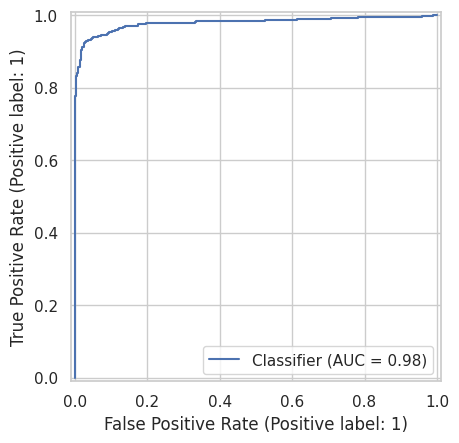

In [ ]:


max_words = 5000
max_len = 100
embedding_dim = 100

# Cargo embeddings preentrenados de GloVe
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_embeddings = load_glove_embeddings("/content/drive/My Drive/Proyecto_IA/glove.6B.100d.txt")

# Creao la matriz de embeddings
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#Preparo los datos de texto**
tokenizer = Tokenizer(num_words=max_words, oov_token="unknown")
tokenizer.fit_on_texts(X_train['mensaje_limpio'])

X_train_sequences = tokenizer.texts_to_sequences(X_train['mensaje_limpio'])
X_test_sequences = tokenizer.texts_to_sequences(X_test['mensaje_limpio'])

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')


# Entrada para texto
text_input = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words,
                            output_dim=embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_len,
                            trainable=False)(text_input)  # Embedding no entrenable
pooled_text = GlobalAveragePooling1D()(embedding_layer)

# Entrada para características numéricas
numeric_input = Input(shape=(len(numeric_features),))
numeric_dense = Dense(64, activation='relu')(numeric_input)

# Combino texto y características numéricas
combined = Concatenate()([pooled_text, numeric_dense])
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.4)(combined)
combined = BatchNormalization()(combined)
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.3)(combined)
combined = BatchNormalization()(combined)
output = Dense(1, activation='sigmoid')(combined)


model = Model(inputs=[text_input, numeric_input], outputs=output)


optimizer = Adam(learning_rate=0.0003)  # Optimización con tasa de aprendizaje ajustada
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#Entrenamiento del modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    [X_train_padded, X_train[numeric_features].values],
    y_train,
    validation_data=([X_test_padded, X_test[numeric_features].values], y_test),
    epochs=15,
    batch_size=64,
    verbose=2,
    callbacks=[early_stopping]
)


test_loss, test_accuracy = model.evaluate([X_test_padded, X_test[numeric_features].values], y_test, verbose=0)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")


y_test_pred_prob = model.predict([X_test_padded, X_test[numeric_features].values])  # Probabilidades predichas
y_test_pred = (y_test_pred_prob > 0.5).astype(int)


print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_pred, target_names=['No Spam', 'Spam']))


auc = roc_auc_score(y_test, y_test_pred_prob)
print(f"AUC: {auc:.4f}")

RocCurveDisplay.from_predictions(y_test, y_test_pred_prob)
plt.show()



***El mejor modelo que obtuvimos sin duda***

In [ ]:

# Guardo el modelo sin incluir el optimizador
model.save('/content/drive/My Drive/Proyecto_IA/embeddings_preentrenados.keras', include_optimizer=False)

In [ ]:

# Guardo el modelo en una carpeta de Google Drive
joblib.dump(model, '/content/drive/My Drive/Proyecto_IA/embbedings_preentrenados.pkl')

print("Modelo guardado exitosamente en Google Drive")

Modelo guardado exitosamente en Google Drive


##**SHAP**

In [ ]:

import shap


# Defino la función de predicción para SHAP
def predict_fn(X):
    """Función contenedora para realizar predicciones con el modelo combinado."""
    text_data = X[:, :max_len]  # Texto
    numeric_data = X[:, max_len:]  # Numéricas
    return model.predict([text_data, numeric_data]).flatten()

# Convierto el X_test a formato necesario para SHAP
X_test_text = pad_sequences(
    tokenizer.texts_to_sequences(X_test['mensaje_limpio']),
    maxlen=max_len,
    padding='post',
    truncating='post'
)
X_test_numeric = X_test[numeric_features].values

# Combino texto y características numéricas en una matriz única
X_test_combined = np.hstack([X_test_text, X_test_numeric])

# Obtengo el índice de palabras reales del tokenizer
word_index = tokenizer.word_index
index_to_word = {v: k for k, v in word_index.items()}

# Creo nombres descriptivos para características usando palabras reales
text_feature_names = []
for i in range(max_len):
    palabra_index = i + 1
    palabra_real = index_to_word.get(palabra_index, f"palabra_{palabra_index}")
    text_feature_names.append(palabra_real)

# Uno nombres reales con características numéricas
feature_names = text_feature_names + numeric_features

# Creo un conjunto representativo
representative_data = shap.sample(X_test_combined, 60)  # Selección de 60 filas

# Creo el explainer
explainer = shap.KernelExplainer(predict_fn, representative_data)

# Calculo valores SHAP para una muestra reducida de datos
shap_values = explainer.shap_values(X_test_combined[:50], nsamples=500)




2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
938/938 ━━━━━━

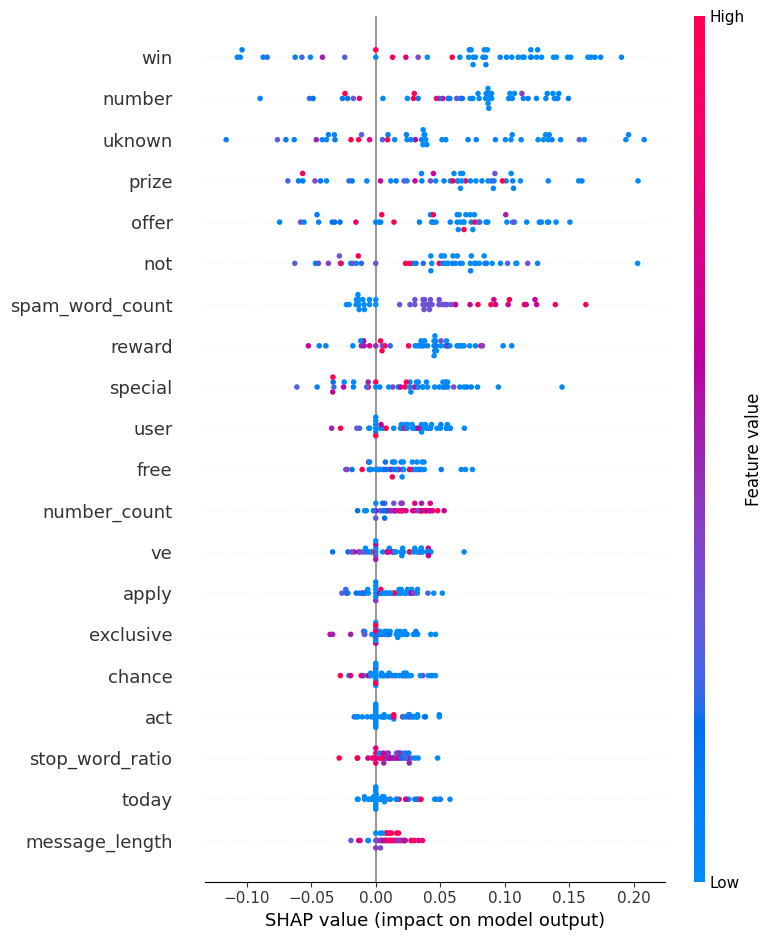

In [ ]:
# Visualización resumen con nombres reales
shap.summary_plot(
    shap_values,
    X_test_combined[:50],
    feature_names=feature_names
)